In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import joblib

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16,10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
df = pd.read_csv('airbnb_nyc_2019.csv')

In [3]:
df.shape

(48895, 16)

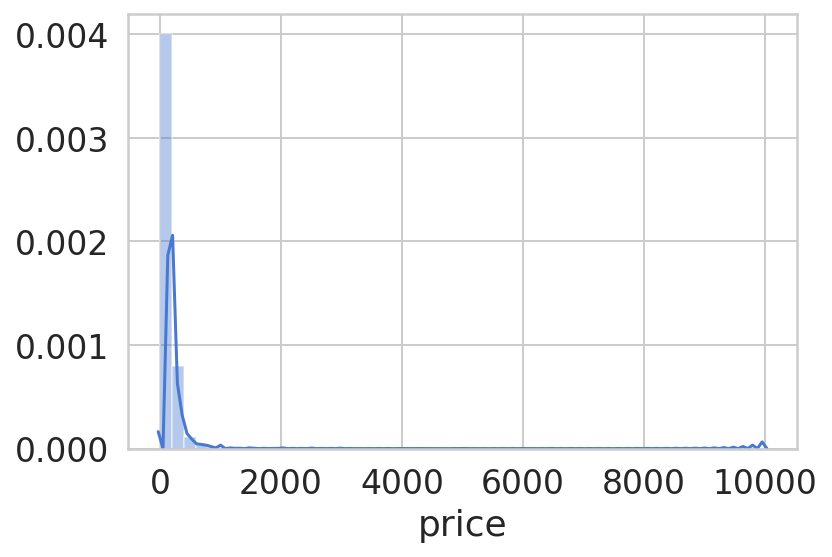

In [4]:
sns.distplot(df.price)

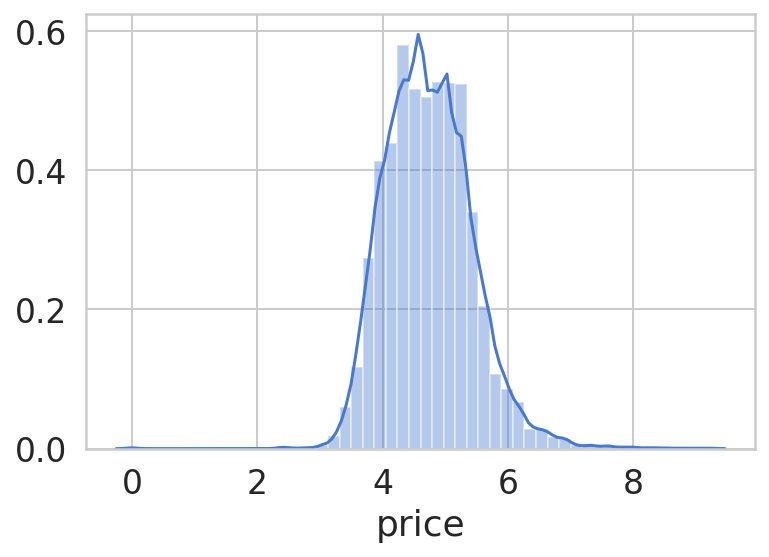

In [5]:
sns.distplot(np.log1p(df.price))

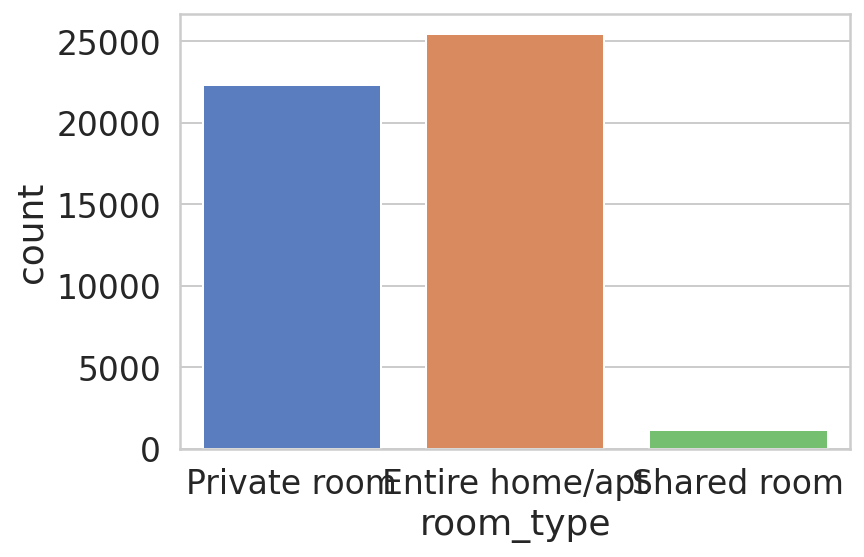

In [6]:
sns.countplot(x='room_type', data=df)

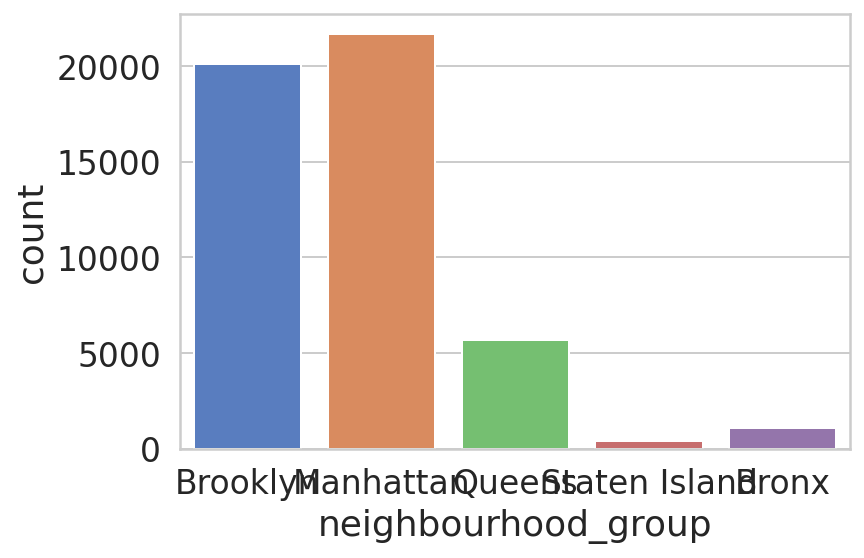

In [7]:
sns.countplot(x='neighbourhood_group', data=df)

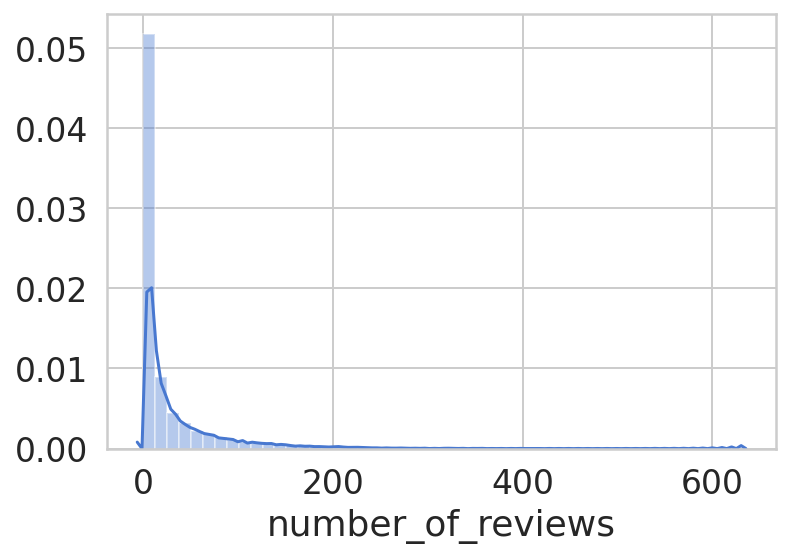

In [8]:
sns.distplot(df.number_of_reviews)

In [9]:
corr_matrix = df.corr()
price_corr = corr_matrix['price']
price_corr.iloc[price_corr.abs().argsort()]

id                                0.010619
host_id                           0.015309
reviews_per_month                -0.030608
latitude                          0.033939
minimum_nights                    0.042799
number_of_reviews                -0.047954
calculated_host_listings_count    0.057472
availability_365                  0.081829
longitude                        -0.150019
price                             1.000000
Name: price, dtype: float64

In [10]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

reviews_per_month    10052
last_review          10052
host_name               21
name                    16
dtype: int64

In [11]:
df = df.drop(['id', 'name', 'host_id', 'host_name', 'reviews_per_month', 'last_review', 'neighbourhood'], axis=1)

In [12]:
df

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,1,0
...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,40.67853,-73.94995,Private room,70,2,0,2,9
48891,Brooklyn,40.70184,-73.93317,Private room,40,4,0,2,36
48892,Manhattan,40.81475,-73.94867,Entire home/apt,115,10,0,1,27
48893,Manhattan,40.75751,-73.99112,Shared room,55,1,0,6,2


In [13]:
x = df.drop('price', axis=1)
y = np.log1p(df.price.values)

In [14]:
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (MinMaxScaler(), [
        'latitude', 'longitude', 'minimum_nights', 
        'number_of_reviews', 'calculated_host_listings_count', 'availability_365'
    ]
),
(OneHotEncoder(handle_unknown='ignore'), ['neighbourhood_group', 'room_type'])
)

In [15]:
transformer.fit(x)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('minmaxscaler',
                                 MinMaxScaler(copy=True, feature_range=(0, 1)),
                                 ['latitude', 'longitude', 'minimum_nights',
                                  'number_of_reviews',
                                  'calculated_host_listings_count',
                                  'availability_365']),
                                ('onehotencoder',
                                 OneHotEncoder(categorical_features=None,
                                               categories=None, drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='ignore',
                                               n_values=None, sparse=True),
                                 ['neighbourhood_group', 'room_type'])],
  

In [16]:
x = transformer.transform(x)

In [17]:
x_train, x_test, y_train, y_test =\
    train_test_split(x,y,test_size=0.2,random_state=RANDOM_SEED)

In [18]:
model = keras.Sequential()
model.add(keras.layers.Dense(
    units=64,
    activation='relu',
    input_shape = [x_train.shape[1]]
    ))
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(
    units=32, activation='relu'
))
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(1))


In [19]:
model.compile(
    optimizer = keras.optimizers.Adam(0.0001),
    loss = 'mae',
    metrics = ['mae']
)

In [20]:
BATCH_SIZE = 32

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_mae',
    mode='min',
    patience=10
)

history = model.fit(
    x=x_train,
    y=y_train,
    shuffle=True,
    epochs=100, 
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop]
)

Train on 31292 samples, validate on 7824 samples
Epoch 1/100
31292/31292 [==============================] - 3s 87us/sample - loss: 2.3727 - mae: 2.3727 - val_loss: 0.5337 - val_mae: 0.5337
Epoch 2/100
31292/31292 [==============================] - 2s 63us/sample - loss: 1.2062 - mae: 1.2062 - val_loss: 0.4731 - val_mae: 0.4731
Epoch 3/100
31292/31292 [==============================] - 2s 64us/sample - loss: 1.1512 - mae: 1.1512 - val_loss: 0.4760 - val_mae: 0.4760
Epoch 4/100
31292/31292 [==============================] - 2s 65us/sample - loss: 1.1112 - mae: 1.1112 - val_loss: 0.4637 - val_mae: 0.4637
Epoch 5/100
31292/31292 [==============================] - 2s 65us/sample - loss: 1.0833 - mae: 1.0833 - val_loss: 0.4529 - val_mae: 0.4529
Epoch 6/100
31292/31292 [==============================] - 2s 64us/sample - loss: 1.0507 - mae: 1.0507 - val_loss: 0.4628 - val_mae: 0.4628
Epoch 7/100
31292/31292 [==============================] - 2s 64us/sample - loss: 1.0331 - mae: 1.0331 - val_lo

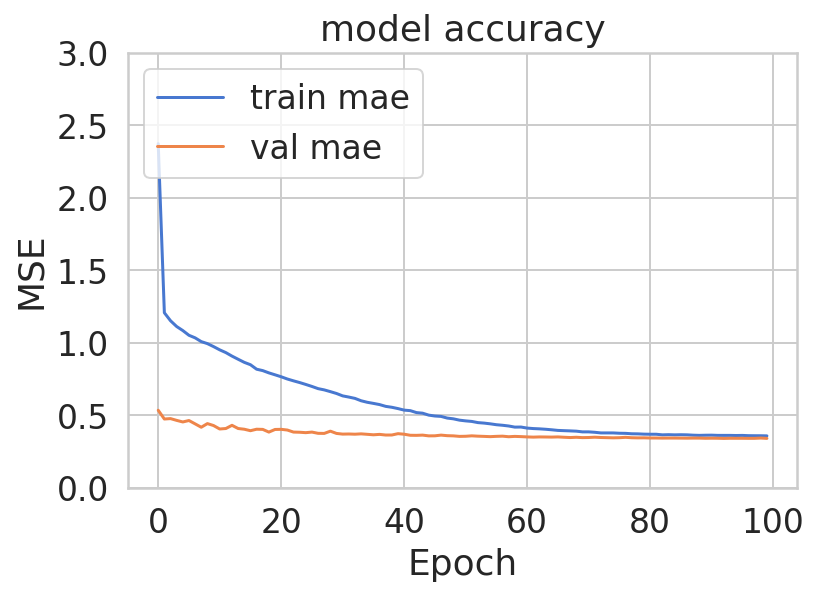

In [21]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model accuracy')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.ylim((0, 3)) # Uncomment this when showing you model for pay raise
plt.legend(['train mae', 'val mae'], loc='upper left');

In [22]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

y_pred = model.predict(x_test)

print(f'MSE {mean_squared_error(y_test, y_pred)}')
print(f'RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}')

MSE 0.2189777593189481
RMSE 0.467950594955224


array([[4.9295635],
       [4.0630007],
       [4.5762835],
       ...,
       [4.0488176],
       [5.1768517],
       [4.815086 ]], dtype=float32)